# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений.

In [3]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [4]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [5]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [6]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше).
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо. Везде считайте $r < m, n$.

In [24]:
def als_functional(A, A_norm, U, Vt):
    UVt_norm_sq = np.trace((U.T @ U) @ (Vt @ Vt.T))

    A_UVt_inner_product = np.sum((A.T @ U) * Vt.T)

    return np.sqrt(A_norm**2 + UVt_norm_sq - 2 * A_UVt_inner_product)

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

Ортопроекторы на $\mathrm{Im}(U_{1})$ и $\mathrm{Im}(U_{2})$ будут иметь вид $P_{1} = U_{1}U_{1}^T$ и $P_{2} =  U_{2}U_{2}^T$ по следствию из теоремы из лекции 3, $\left\lvert \left\lvert P_{1} - P_{2}\right\rvert\right\rvert_{2} = \sigma_{max}(P_{1} - P_{2})$.

Пусть $D = P_1 - P_2 = U_1U_1^T - U_2U_2^T$, следовательно,
$$
D = [U_{1}, U_{2}]\cdot [U_{1}, -U_{2}]^T
$$

Нужное нам сингулярное разложение $D$ искать в лоб очень дорого $-$ $\mathcal{O}(m^3)$, поэтому будем использовать $QR$ - разложение.

$[U_1, U_2] \in \mathbb{R}^{m\times 2r}$, $[U_1, -U_2] \in \mathbb{R}^{m\times 2r}$, следовательно, $QR$-разложение для них делается за $\mathcal{O}(mr^2)$.
$$
[U_{1}, U_{2}] \overset{QR}{\to} Q_{1}R_{1},\quad [U_{1}, -U_{2}] \overset{QR}{\to} Q_{2}R_{2}
$$
Матрицы $Q_i$ имеют ортонормированные столбцы. Ищем $SVD$ от матрицы $R_1R_2^T \in \mathbb{R}^{2r\times 2r}$ $-$ мы это делаем за $\mathcal{O}(r^3)$ $<$ $\mathcal{O}(mr^2)$ ($r < m$): $R_{1}R_{2}^T = U\Sigma V^T$.
$$
\left\lvert\left\lvert A\right\rvert\right\rvert_{2} = \left\lvert\left\lvert Q_{1}R_{1}R_{2}^TQ_{2}^T\right\rvert\right\rvert_{2} = \left\lvert\left\lvert Q_{1}U\Sigma V^TQ_{2}^T\right\rvert\right\rvert_{2}
$$
При этом:
$$
V^TQ_{2}^T\cdot Q_{2}V = V^TIV = I = (Q_{2}V)^T\cdot (Q_{2}V)
$$

Следовательно, матрица $Q_2V$ имеет ортонормированные столбцы, матрица $Q_1$ тоже имеет ортонормированные столбцы, а U - унитарная $-$ из этого мы получаем, что:
$$
\left\lvert\left\lvert A\right\rvert\right\rvert_{2} = \left\lvert\left\lvert Q_{1}U\Sigma V^TQ_{2}^T Q_{2}V\right\rvert\right\rvert_{2} = \left\lvert\left\lvert \Sigma \right\rvert\right\rvert_{2}
$$
Следовательно, искомое расстояние $-$ старшее сингулярное число матрицы $R_1R_2^T$ (находим за $\mathcal{O}(mr^2)$).

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [25]:
def dist_between_subspaces(U1, U2):
    Q1, R1 = np.linalg.qr(np.block([U1, U2]))
    Q2, R2 = np.linalg.qr(np.block([U1, -U2]))

    return np.linalg.svd(R1 @ R2.T, compute_uv=False)[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|P(U_{k-1}) - P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию.

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [26]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    A_norm = sparse_norm(A)
    m, n = A.shape
    U, V = np.linalg.qr(np.random.randn(m, rank))[0], np.random.randn(n, rank)
    fs, deltas, dists = [als_functional(A, A_norm, U, V.T)], [0], [0]
    iteration = 0

    while True:
        iteration += 1
        V = np.linalg.qr(V)[0]
        U_new, _ = np.linalg.qr(A @ V)
        V = A.T @ U_new

        dists.append(dist_between_subspaces(U, U_new))

        U = U_new

        fs.append(als_functional(A, A_norm, U, V.T))

        deltas.append(fs[-2] - fs[-1])

        if debug:
            print(f"Итерация {iteration}: значение функционала = {fs[-1]:.6f}, изменение значения функционала = {deltas[-1]:.6f}, расстояние между подпространствами = {dists[-1]:.6f}")

        if deltas[-1] <= tolerance:
            break

    return U, V.T, fs, deltas, dists

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

Итерация 1: значение функционала = 1799.072166, изменение значения функционала = 639.934662, расстояние между подпространствами = 0.999999
Итерация 2: значение функционала = 1660.121769, изменение значения функционала = 138.950397, расстояние между подпространствами = 0.887856
Итерация 3: значение функционала = 1645.141752, изменение значения функционала = 14.980017, расстояние между подпространствами = 0.527121
Итерация 4: значение функционала = 1640.513794, изменение значения функционала = 4.627958, расстояние между подпространствами = 0.368045
Итерация 5: значение функционала = 1638.585063, изменение значения функционала = 1.928731, расстояние между подпространствами = 0.284182
Итерация 6: значение функционала = 1637.680373, изменение значения функционала = 0.904690, расстояние между подпространствами = 0.204149
Итерация 7: значение функционала = 1637.203618, изменение значения функционала = 0.476755, расстояние между подпространствами = 0.153921
Итерация 8: значение функционала = 1

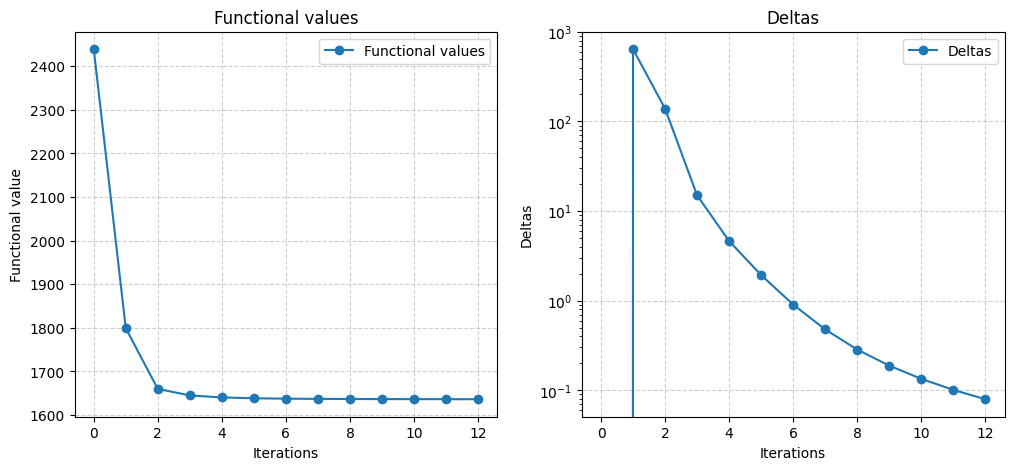

In [27]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs, marker='o', linestyle='-', label='Functional values')
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Functional value")
axs[0].set_title("Functional values")
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

axs[1].plot(deltas, marker='o', linestyle='-', label="Deltas")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Deltas")
axs[1].set_title("Deltas")
axs[1].semilogy()
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

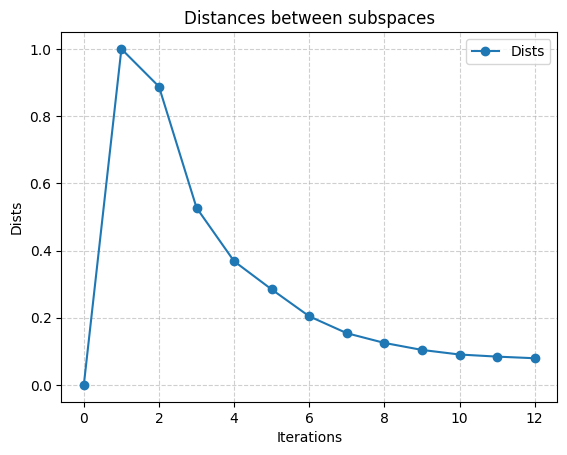

In [28]:
plt.plot(dists, marker='o', linestyle='-', label="Dists")
plt.xlabel("Iterations")
plt.ylabel("Dists")
plt.title("Distances between subspaces")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [29]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

In [54]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)

als_val = als_functional(A_train, A_norm, U_als, VT_als)
print(f"ALS functional: {als_val:.6f}")

U, S, VT = randomized_svd(A_train, n_components=rank, random_state=25)
rand_svd_val = als_functional(A_train, A_norm, U * S, VT)
print(f"Randomized SVD functional: {rand_svd_val:.6f}")

U, S, VT = svds(A_train, k=rank)
sparse_val = als_functional(A_train, A_norm, U * S, VT)
print(f"Sparse SVD functional: {sparse_val:.6f}")

ALS functional: 1636.416473
Randomized SVD functional: 1636.021606
Sparse SVD functional: 1635.937744


## d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.  **Подсказка:** используйте функцию `np.argsort`.

In [7]:
def recommend(VT, known_ratings, n_recs):
    predicted_ratings = known_ratings @ VT.T @ np.linalg.inv(VT @ VT.T) @ VT

    recs = np.argsort(-predicted_ratings, axis=1)[:, :n_recs]

    return recs

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [8]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [58]:
def get_hit_rates(VT, A_test, n_recs):
    hit_idxs = np.array(evaluate_model(VT, A_test, max(n_recs)))

    hit_rates = [np.mean(hit_idxs < n) for n in n_recs]

    return hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [92]:
_, _, VT = svds(A_train, k=30)

hit_rates = get_hit_rates(VT, A_test[:1000], [10])

print(f"hit rate - {hit_rates[0]*100:.4f}%")

hit rate - 11.4990%


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

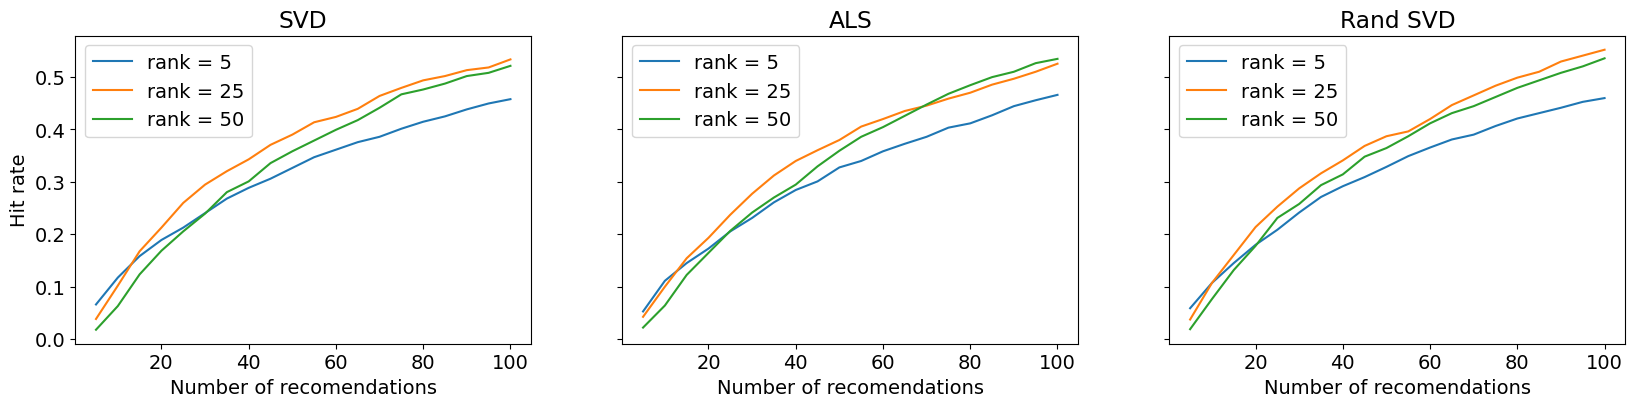

In [93]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

По графикам видно, что оптимальный ранг равен 25 - при ранге, равном 5, мы получаем заметно меньшие значения хитрейта, а при ранге 50 разница со случаем, где ранг 25, минимальна.

## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

In [ ]:
def tuck2full(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            A: d-dimensional numpy array of the size (n1, n2, ..., nd)
    """
    # TO BE FILLED
    raise NotImplementedError()

2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [ ]:
def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)
    """
    # TO BE FILLED
    raise NotImplementedError()

3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [ ]:
# TO BE FILLED

4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

**YOUR WORDS GO HERE**

5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

In [ ]:
def tuck_norm(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            norm: Frobenius norm of A = [G; U1 ... Ud]
    """
    # TO BE FILLED
    raise NotImplementedError()